Checking the counts of the images

In [18]:
import os

directory = "annotations" # directory where the txt files are located
files = os.listdir(directory) # get the list of all files in the directory

counts = []
for file in files:
    if file.endswith(".txt"): # check if the file is a txt file
        path = os.path.join(directory, file) # get the full path of the file
        with open(path, 'r') as f:
            num_rows = sum(1 for line in f) # count the number of rows in the file
            print(f"{file}: {num_rows}")
            counts.append(num_rows)

total_samples = sum(counts)
class_weights = np.array([total_samples / count for count in counts])
class_weights /= class_weights.sum() # normalize the weights to sum to 1
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

print(f'example class init weights: {class_weights}')

night.txt: 598
people.txt: 6403
baby.txt: 95
female.txt: 3227
flower.txt: 761
car.txt: 319
portrait.txt: 3121
bird.txt: 360
clouds.txt: 1095
dog.txt: 448
male.txt: 2979
river.txt: 120
tree.txt: 525
sea.txt: 173
[0.04211008 0.00393282 0.26507189 0.00780348 0.03309045 0.0789399
 0.00806851 0.06994953 0.0229971  0.05620944 0.00845311 0.20984858
 0.04796539 0.14555971]


## Multi-class classifier

In [1]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torch.utils.data
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn 
import torch.nn.functional as F
import numpy as np
import os
from PIL import Image
import torch.backends.mps
import matplotlib.pyplot as plt

In [114]:
#--- hyperparameters ---
N_EPOCHS = 10
LR = 0.01
DROPOUT_RATE = 0.5

#--- fixed constants ---
NUM_CLASSES = 14
DATA_DIR = 'dataset/%s'
NUM_CHANNELS = 3
WIDTH, HEIGHT = 128, 128
MEAN = [0.45183619, 0.4171191, 0.3778775 ]
SD = [0.24016619, 0.23024313, 0.22750713]

In [107]:
train_transform = transforms.Compose([
                                        transforms.RandomHorizontalFlip(),
                                        #transforms.RandomResizedCrop(128),
                                        #transforms.Grayscale(),
                                        transforms.ToTensor()])#,
                                        #transforms.Normalize(MEAN, SD)])
val_transform = transforms.Compose([
                                        #transforms.Grayscale(),
                                        #transforms.Resize(256),
                                        #transforms.CenterCrop(128),
                                        transforms.ToTensor()])#,
                                        #transforms.Normalize(MEAN, SD)])

test_transform = transforms.Compose([
                                        transforms.ToTensor()])#,
                                        #transforms.Normalize(MEAN, SD)])

In [180]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = os.listdir(os.path.join(self.root_dir, "images"))
        self.labels = {}
        for label in ['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']:
            with open(os.path.join(self.root_dir, "annotations", f"{label}.txt"), "r") as f:
                f.seek(0)
                self.labels[label] = set(f.read().splitlines())
                # self.labels[label] = set(f.read().splitlines()) # this is original

    def __len__(self):
        return len(self.image_paths)

    #def get_labels(self):
    #    return self.labels

    def get_labels(self):
        labels = []
        for i in range(len(self)):
            image_path = os.path.join(self.root_dir, "images", self.image_paths[i])
            label = []
            for key, value in self.labels.items():
                filename = os.path.basename(image_path)[2:-4]
                label.append(1 if filename in value else 0)
            labels.append(label)
        return np.array(labels)

    def __getitem__(self, index):
        image_path = os.path.join(self.root_dir, "images", self.image_paths[index])
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = []
        for key, value in self.labels.items():
            filename = os.path.basename(image_path)[2:-4]
            #print(filename)
            label.append(1 if filename in value else 0)

        label = torch.tensor(label, dtype=torch.float32)
        #print(label.shape)
        return image, label, index, image_path
        

In [207]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import DataLoader, Subset

# set here the path where the images and annotations are
path = ""

# load the data
dataset = CustomDataset(path, transform=None)

#X = dataset.image_paths
#y = dataset.get_labels()
#print(X, y)
#from collections import Counter
#print(Counter(np.argmax(y, axis=1)))
#
#sss = StratifiedShuffleSplit(n_splits=2, test_size=0.5, random_state=42)
#train_index, test_index = next(sss.split(X, y))
#train_dataset = Subset(dataset, train_index)
#test_dataset = Subset(dataset, test_index)


# Define the sizes of the splits
train_size = int(0.5 * len(dataset))
val_size = int(0.25 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split the dataset randomly into train, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_dataset.dataset = CustomDataset(path, transform=train_transform)
val_dataset.dataset = CustomDataset(path, transform=val_transform)
test_dataset.dataset = CustomDataset(path, transform=test_transform)


# Create data loaders for each set
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [110]:
class MultiLabelClassifier(nn.Module):
    def __init__(self):
        super(MultiLabelClassifier, self).__init__()
        self.conv1 = nn.Conv2d(NUM_CHANNELS, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, NUM_CLASSES)
        self.drop = nn.Dropout(p=DROPOUT_RATE)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 32 * 32)
        x = self.drop(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class ComplexMultiLabelClassifier(nn.Module):
    def __init__(self):
        super(ComplexMultiLabelClassifier, self).__init__()
        self.conv1 = nn.Conv2d(NUM_CHANNELS, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, NUM_CLASSES)
        self.drop = nn.Dropout(p=DROPOUT_RATE)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 32 * 32)
        x = self.drop(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x.view(-1, NUM_CLASSES)

class SimpleMultiLabelClassifier(nn.Module):
    def __init__(self):
        super(SimpleMultiLabelClassifier, self).__init__()
        self.conv = nn.Conv2d(NUM_CHANNELS, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(16 * 64 * 64, NUM_CLASSES)
        self.drop = nn.Dropout(p=DROPOUT_RATE)
    
    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv(x)))
        x = x.view(-1, 16 * 64 * 64)
        x = self.drop(x)
        x = self.fc(x)
        x = self.drop(x)
        return x

    
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        focal_loss = self.alpha * (1 - pt)**self.gamma * BCE_loss
        return torch.mean(focal_loss)

class FocalLossV2(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLossV2, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.bce = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt)**self.gamma * bce_loss
        return torch.mean(focal_loss)        


In [125]:
model = MultiLabelClassifier()

device = torch.device('cpu')

# set up device
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    if torch.backends.mps.is_built():
        device = torch.device('mps')


print(device)

model = ComplexMultiLabelClassifier().to(device)

# Define your loss function and optimizer
criterion = FocalLossV2(alpha=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=LR)

# parameters for early stop
threshold = 3       # number of epochs to wait if test loss doesnt improve
min_loss = np.inf
counter = 0

# Train your model
for epoch in range(N_EPOCHS):
    train_loss = 0.0
    train_correct = 0.0
    train_total = 0
    total_zero = 0

    model.train()
    for i, data in enumerate(train_loader):
        inputs, labels, index, path = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        
        # calculate accuracy
        predictions = (torch.sigmoid(outputs) > 0.5).int()
        correct = torch.eq(predictions, labels).sum().item()

        train_correct += correct

        # En oo iha varma miten tätä pitäs tulkita, atm laskee siis jokasen oikeen arvauksen ja yhen kuvan sisällä on käytännössä 14 arvausta
        train_total += labels.size(0)*NUM_CLASSES
        loss = criterion(outputs, labels)
        train_loss += loss
        loss.backward()
        optimizer.step()

        if predictions.sum() == 0:
            total_zero += 1

        # print('predictions',predictions)
        # print('labels',labels)
    
    # calculate average loss and accuracy for epoch
    epoch_loss = train_loss / len(train_loader)
    epoch_accuracy = train_correct / train_total
    
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {epoch_loss:.3f} | Train Acc: {epoch_accuracy*100:.2f}%')
    print(f'\t Total Zero: {total_zero}  |  Zero Rate: {total_zero/len(val_loader)*100:.2f}%')

    model.eval()
    # evaluate model on validation set
    with torch.no_grad():
        val_loss = 0
        val_correct = 0
        val_total = 0
        total_zero = 0

        for i, data in enumerate(val_loader):
            inputs, labels, index, path = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
            # calculate accuracy
            predictions = (torch.sigmoid(outputs) > 0.5).int()
            correct = torch.eq(predictions, labels).sum().item()
            val_correct += correct

            val_total += labels.size(0)*NUM_CLASSES
            val_loss += loss

            if predictions.sum() == 0:
                total_zero += 1

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

    print(f'\t Val. Loss: {val_loss:.3f} |  Val. Acc: {val_acc*100:.2f}%')
    print(f'\t Total Zero: {total_zero}  |  Zero Rate: {total_zero/len(val_loader)*100:.2f}%')

    # early stopping
    if val_loss < min_loss:
        min_loss = val_loss
        counter = 0
    else:
        counter += 1
        if counter >= threshold:
            print(f'Stopping early after epoch {epoch}, best loss reached.')
            break
            

cpu
Epoch: 01
	Train Loss: 0.012 | Train Acc: 92.37%
	 Total Zero: 304  |  Zero Rate: 193.63%
	 Val. Loss: 0.012 |  Val. Acc: 92.74%
	 Total Zero: 157  |  Zero Rate: 100.00%
Epoch: 02
	Train Loss: 0.012 | Train Acc: 92.72%
	 Total Zero: 311  |  Zero Rate: 198.09%
	 Val. Loss: 0.012 |  Val. Acc: 92.74%
	 Total Zero: 157  |  Zero Rate: 100.00%


KeyboardInterrupt: 

In [90]:
torch.save(model.state_dict(), 'model.pth')

In [ ]:
model = MultiLabelClassifier().to(device)
model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

In [91]:
#--- test ---

with torch.no_grad():
    test_loss = 0
    test_correct = 0
    test_total = 0
    total_zero = 0
    for i, data in enumerate(test_loader):
        inputs, labels, index, path = data
        inputs, labels = inputs.to(device), labels.to(device)
        #print(labels.shape)
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)

        # calculate accuracy
        predictions = (outputs > 0.5).int()
        
        correct = torch.eq(predictions, labels).sum().item()
        test_correct += correct

        test_total += labels.size(0)*NUM_CLASSES
        test_loss += loss

        if predictions.sum() == 0:
            total_zero += 1

    test_loss /= len(test_loader)
    test_acc = test_correct / test_total

print(f'Test Loss: {test_loss:.3f} |  Test Acc: {test_acc*100:.2f}%')
print(f'\t Total Zero: {total_zero}  |  Zero Rate: {total_zero/len(val_loader)*100:.2f}%')

Test Loss: 0.028 |  Test Acc: 72.35%
	 Total Zero: 0  |  Zero Rate: 0.00%


tensor([[-0.9307, -0.7307, -0.7649, -0.5392, -0.7495, -0.2864, -0.5985, -0.2777,
         -0.7041, -0.1052, -0.2693, -0.9375, -0.9416, -0.7097]],
       grad_fn=<AddmmBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)


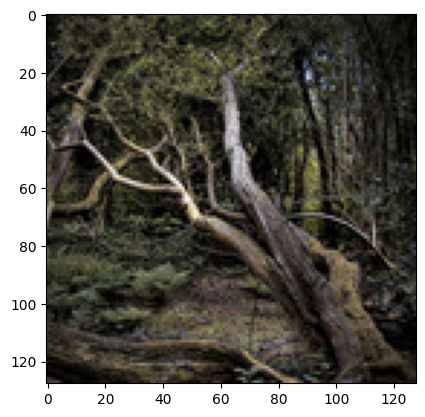

tensor([[-0.9307, -0.7307, -0.7649, -0.5392, -0.7495, -0.2864, -0.5985, -0.2777,
         -0.7041, -0.1052, -0.2693, -0.9375, -0.9416, -0.7097]],
       grad_fn=<AddmmBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)


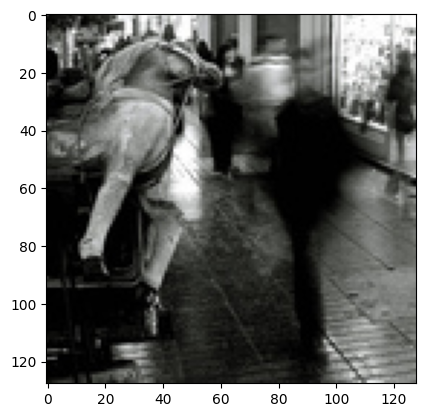

tensor([[-0.9307, -0.7307, -0.7649, -0.5392, -0.7495, -0.2864, -0.5985, -0.2777,
         -0.7041, -0.1052, -0.2693, -0.9375, -0.9416, -0.7097]],
       grad_fn=<AddmmBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)


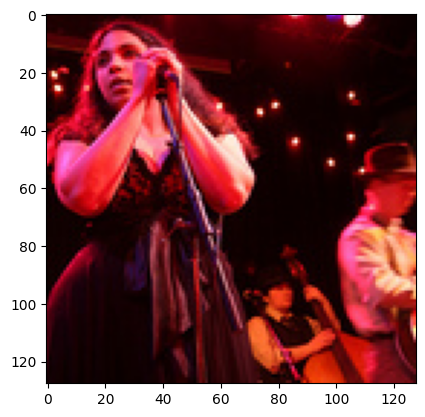

tensor([[-0.9307, -0.7307, -0.7649, -0.5392, -0.7495, -0.2864, -0.5985, -0.2777,
         -0.7041, -0.1052, -0.2693, -0.9375, -0.9416, -0.7097]],
       grad_fn=<AddmmBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)


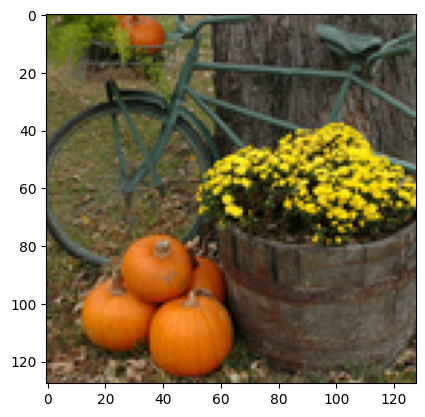

tensor([[-0.9307, -0.7307, -0.7649, -0.5392, -0.7495, -0.2864, -0.5985, -0.2777,
         -0.7041, -0.1052, -0.2693, -0.9375, -0.9416, -0.7097]],
       grad_fn=<AddmmBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)


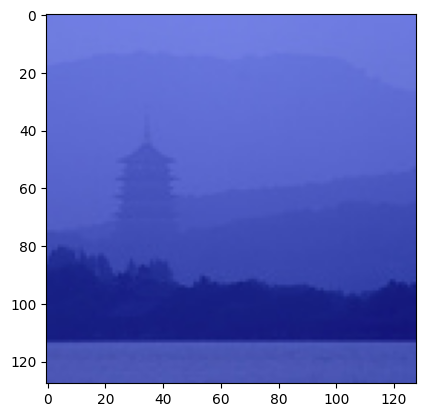

tensor([[-0.9334, -0.7330, -0.7681, -0.5407, -0.7517, -0.2865, -0.6008, -0.2788,
         -0.7081, -0.1060, -0.2693, -0.9420, -0.9433, -0.7128]],
       grad_fn=<AddmmBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)


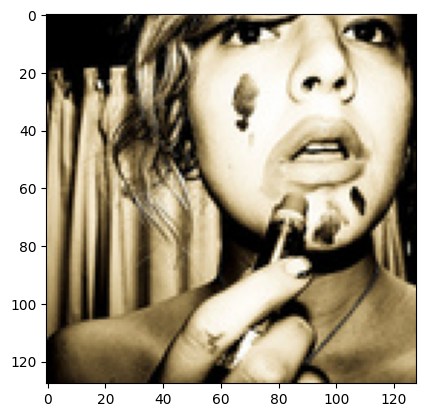

tensor([[-0.9307, -0.7307, -0.7649, -0.5392, -0.7495, -0.2864, -0.5985, -0.2777,
         -0.7041, -0.1052, -0.2693, -0.9375, -0.9416, -0.7097]],
       grad_fn=<AddmmBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)


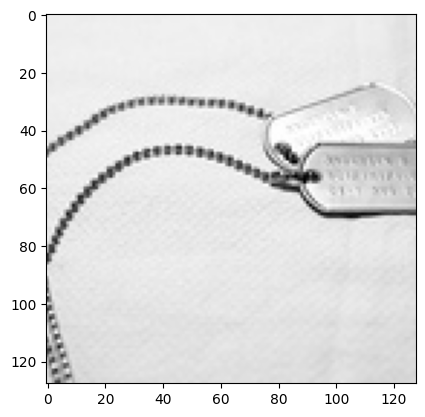

tensor([[-0.9307, -0.7307, -0.7649, -0.5392, -0.7495, -0.2864, -0.5985, -0.2777,
         -0.7041, -0.1052, -0.2693, -0.9375, -0.9416, -0.7097]],
       grad_fn=<AddmmBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)


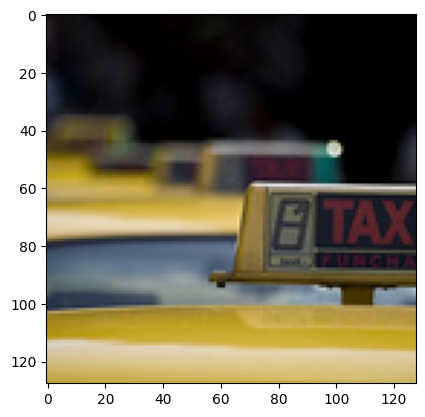

tensor([[-0.9307, -0.7307, -0.7649, -0.5392, -0.7495, -0.2864, -0.5985, -0.2777,
         -0.7041, -0.1052, -0.2693, -0.9375, -0.9416, -0.7097]],
       grad_fn=<AddmmBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)


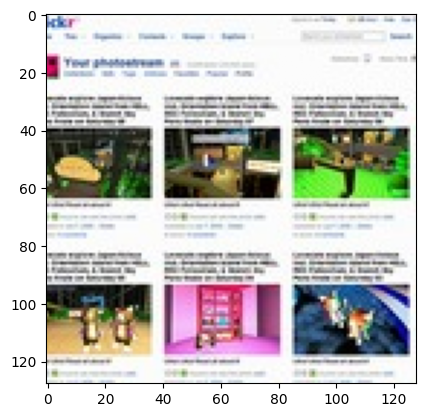

tensor([[-0.9310, -0.7310, -0.7650, -0.5394, -0.7494, -0.2859, -0.5984, -0.2780,
         -0.7042, -0.1052, -0.2690, -0.9377, -0.9418, -0.7100]],
       grad_fn=<AddmmBackward0>)
['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
label tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

pred tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)


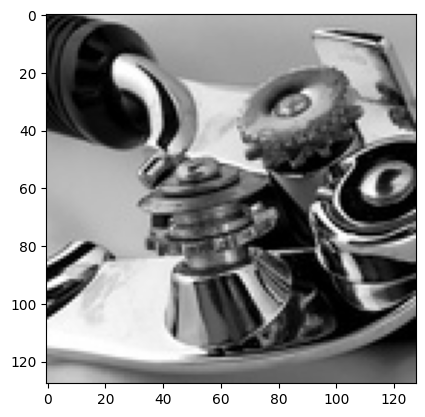

In [124]:
def testN(num_pics):
    test_total = 0
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    for i, data in enumerate(test_loader):
        test_total += 1
        if test_total > num_pics:
            break
        input, label, index, path = data
        input, label = input.to(device), label.to(device)
        output = model.forward(input)
        predictions = (torch.sigmoid(output) > 0.5).int()
        print(output)
        print(['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree'])
        print('label',label)
        print()
        print('pred', predictions)

        image_array = input.numpy()
        plt.imshow(image_array.transpose((2, 3, 1, 0)).squeeze(3))
        plt.show()


testN(10)